
Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Mininum Variance Portfolio", value begin = $ 991452.06, value end = $ 1016146.40
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.38, value end = $ 1007859.12
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 992755.56, value end = $ 1018573.09
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 985531.37, value end = $ 1037572.45
  Strategy "Robust Optimization Portfolio", value begin = $ 992229.17, value end = $ 1002809.97

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030724.21, value end = $ 1011178.46
  Strategy "

  Strategy "Mininum Variance Portfolio", value begin = $ 1006993.29, value end = $ 1121043.22
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1157418.19, value end = $ 1535669.63
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1134051.42, value end = $ 1243947.37
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1218285.72, value end = $ 1432823.90
  Strategy "Robust Optimization Portfolio", value begin = $ 1049213.68, value end = $ 1134598.80


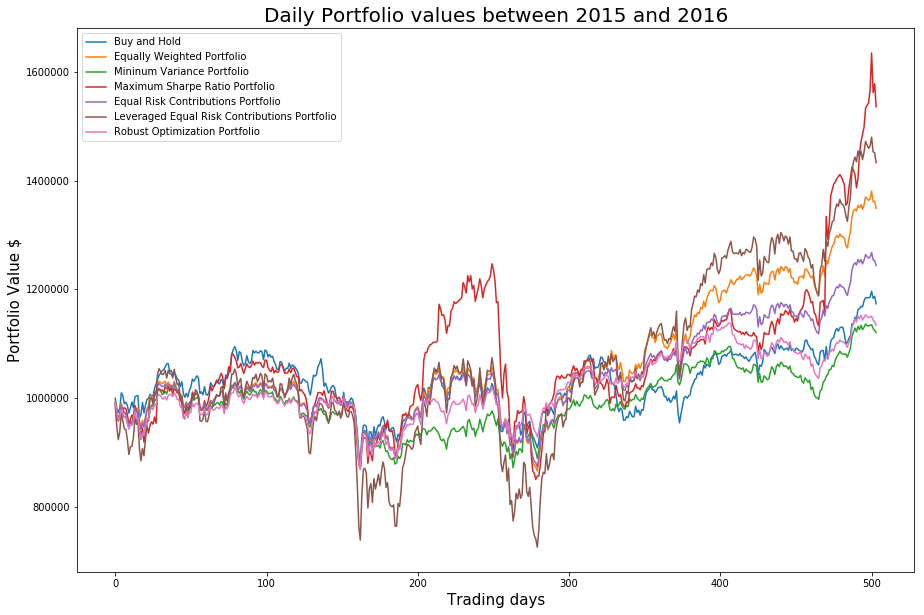

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cvxpy as cp
import cplex
import matplotlib.pyplot as plt
import ipopt
import copy

# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    portfolio_value = np.sum(x_optimal*cur_prices) + cash_optimal
    w_optimal = (x_optimal*cur_prices)/portfolio_value
   
    return x_optimal, cash_optimal, w_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init                 #Calculation of total value begin
    allocated_money = np.array(len(x_init)*[portfolio_value/len(x_init)])   #Equally weighted distribution of total money
    x_optimal = np.floor(allocated_money/cur_prices)                        #Rounding down procedure for calculation of shares
                    
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005               #0.5% of transaction cost for both buying and selling
    cash_optimal = portfolio_value - np.sum(cur_prices*x_optimal) - transaction_cost #cash = asset - stock value- transaction cost
    w_optimal = (x_optimal*cur_prices)/portfolio_value

    return x_optimal, cash_optimal, w_optimal 

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    n = len(x_init)
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    
    A = []
    for k in range(n):
        A.append([[0],[1]])

    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")                  
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    w_minVar = cpx.solution.get_values()
    w_minVar = np.asarray(w_minVar)
    
    allocated_money = w_minVar*portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 #Convert the weight optimal to position optimal        
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005               #0.5% of transaction cost
    cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost #cash = asset - stock value- transaction cost

    return x_optimal, cash_optimal, w_minVar

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    
    n = len(x_init)+1
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * n                                   #Value of kappa may greater than 1, thus np.inf is used as bound
    
    daily_r_rf = 1.025**(1.0/252)-1
    diff = mu - daily_r_rf
    
    coe_k = np.zeros((20,1))
    Q = np.hstack((Q,coe_k))
    coe_k = np.zeros((1,21))
    Q = np.vstack((Q,coe_k))                           #Add a column and a row of 0 to allow the optimization of kappa
    
    A = []
    for k in range(20):
        A.append([[0,1],[diff[k],1]])
    A.append([[0,1],[0,-1]])                           #Append -1 so that the constraint becomes [sum(wi)- kappa = 0]
    
    
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    w_maxSharpe = cpx.solution.get_values()
    w_optimal = np.asarray(w_maxSharpe)                         
    w_maxSharpe = w_optimal[0:20]/w_optimal[20]                                      #the weight distribution of maxSharpe
    
    allocated_money = w_maxSharpe*portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 # Convert weight optimal to postion optimal(x_optimal
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005                #0.5% of transaction cost
    cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost #cash = asset - stock value- transaction cost

    return x_optimal, cash_optimal, w_maxSharpe

def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q, x)
            #  use finite differences to check the gradient
            for i in range(n):
                for j in range(n):
                    diff1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i])
                    diff2 = np.dot(Q[i][j], x[i])
                    delta_g = (y[i]-y[j]) * (diff1 - diff2)
                    grad[i] = grad[i] + delta_g
                grad[i] = 2 * 2 * grad[i]
            return grad

        def constraints(self, x):
        # The callback for calculating the constraints
            return [1.0] * n
    
        def jacobian(self, x):
        # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
    
    n = len(x_init)
    w0 = (x_init*cur_prices)/portfolio_value # initial weight distribution
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    
    
    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    w_erc, info = nlp.solve(w0)
    w_erc = np.asarray(w_erc)
    w_erc = w_erc*(1/w_erc.sum())
    
    allocated_money = w_erc*portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 #Convert the weight optimal to position optimal        
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005               #0.5% of transaction cost
    cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost #cash = asset - stock value- transaction cost
 
    return x_optimal, cash_optimal, w_erc

def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    #Use IPOPT solver to calculate equal risk contribution
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q, x)
            #use finite differences to check the gradient
            for i in range(n):
                for j in range(n):
                    diff1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i])
                    diff2 = np.dot(Q[i][j], x[i])
                    delta_g = (y[i]-y[j]) * (diff1 - diff2)
                    grad[i] = grad[i] + delta_g
                grad[i] = 2 * 2 * grad[i] 
            return grad

        def constraints(self, x):
        # The callback for calculating the constraints
            return [1.0] * n
    
        def jacobian(self, x):
        # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
    
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    borrow_value = init_value                                
    interest = borrow_value*0.025/6
    
    if period == 1:
        portfolio_value = portfolio_value + borrow_value        #200% long position in the beginning
    
    n = len(x_init)
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    w0 = (x_init*cur_prices)/portfolio_value
    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    w_lerc, info = nlp.solve(w0)
    w_lerc = np.asarray(w_lerc)
    w_lerc = w_lerc*(1/w_lerc.sum())
    
    allocated_money = w_lerc*portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 #Convert the weight optimal to position optimal        
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005               #0.5% of transaction cost
    cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost - interest #cash = asset - stock value- transaction cost

    return x_optimal, cash_optimal, w_lerc

def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    n = len(x_init)
    w0 = [1.0/n]*n                                         # Weight distribution for 1/n portfolio
    var_matr = np.diag(np.diag(Q))                           # Required portfolio robustness
    rob_init = np.dot(w0, np.dot(var_matr, w0))              # return estimation error of 1/n portfolio
    rob_bnd  = rob_init                                      # Target portfolio return estimation error is return estimation error of 1/n portfolio
    daily_r_rf = 1.025**(1.0/252)-1
    Portf_Retn = daily_r_rf                                  
    # Portfolio return is set as daily risk-free rate of return so that the performance of robust optimization can be used
    # as the strategy performance baseline. It is only worth to invest stock when the strategy gives a higher rate of return
    # than the robust optimization.
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    w_rMV = cpx.solution.get_values()
    # Round near-zero portfolio weights
    w_rMV = np.array(w_rMV)
    #w_rMV_nonrnd = copy.deepcopy(w_rMV)
    w_rMV[w_rMV<1e-6] = 0
    w_rMV = w_rMV / np.sum(w_rMV)
    
    allocated_money = w_rMV*portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 # Convert weight optimal to postion optimal(x_optimal
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005                #0.5% of transaction cost
    cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost #cash = asset - stock value- transaction cost

    return x_optimal, cash_optimal, w_rMV
 

# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 
                      'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 
                      'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr,
           strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 15:
       cur_year  = 15 + math.floor(period/7)
   else:
       cur_year  = 2015 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy][period-1]<0 :
            if cash[5][0]<0:  
                portfolio_value = (np.sum(curr_positions*cur_prices) + curr_cash)*2  # 200% long positon in the beginning for leveraged ERC
            else:
                portfolio_value = np.sum(curr_positions*cur_prices) + curr_cash       #Portfolio value before the balance strategy
            
            ratio = x[strategy][period-1]/np.sum(x[strategy][period-1])           #Determine the current weight distribution
            cash_excess = abs(cash[strategy][period-1])* ratio                    #Distribute over-draft cash by weight to each stock
            position_excess = np.ceil(cash_excess/cur_prices)                     #Determine how many excess shares bought for each stock
            x[strategy][period-1] = x[strategy][period-1] - position_excess       #Recalculation of optimal position of stocks by substracting excess shares bought
            transaction_cost = np.dot(cur_prices, abs(x[strategy][period-1]-curr_positions))*0.005
            
            if strategy ==5:                                                      #Interest cost related to LERC needs to be considered
                cash[strategy][period-1] = portfolio_value - np.sum(cur_prices*x[strategy][period-1]) - transaction_cost - init_value*r_rf/6
            else:
                cash[strategy][period-1] = portfolio_value - np.sum(cur_prices*x[strategy][period-1]) - transaction_cost
    
                

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      if strategy ==5:
        # For Leverage equal risk contribution strategy, the portofolio value should deduct the leverage (money borrowed)
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################
plt.rcParams['figure.figsize'] = [15, 10]
index = 0
for strat in strategy_names:
    plt.plot(portf_value[index], label = strat)
    index = index+1
plt.legend()
plt.ylabel('Portfolio Value $', fontsize=15)
plt.xlabel('Trading days', fontsize=15)
plt.title('Daily Portfolio values between 2015 and 2016', fontsize= 20)
plt.show()

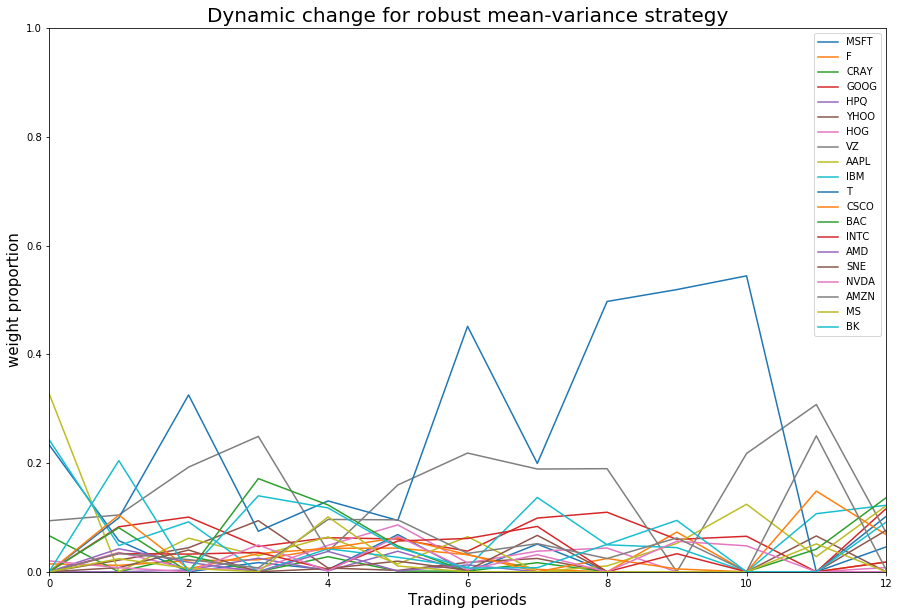

In [3]:
#Dynamic change for robust mean-Variance strategy

names = list(df.columns.values)
stock_names = names[1:]
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])
init_price = init_positions * data_prices[0,:]
init_value = np.dot(data_prices[0,:], init_positions)
w_initial = init_price / init_value

for i in range(20):
    stock_weight =[w_initial[i]]
    period = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    for j in range(12):
        stock_weight.append(weight[6][j][i])
    plt.plot(period,stock_weight, label = stock_names[i])
plt.legend()
plt.ylim([0,1])
plt.xlim([0,12])


plt.ylabel('weight proportion', fontsize=15);
plt.xlabel('Trading periods', fontsize=15);
plt.title('Dynamic change for robust mean-variance strategy', fontsize = 20);

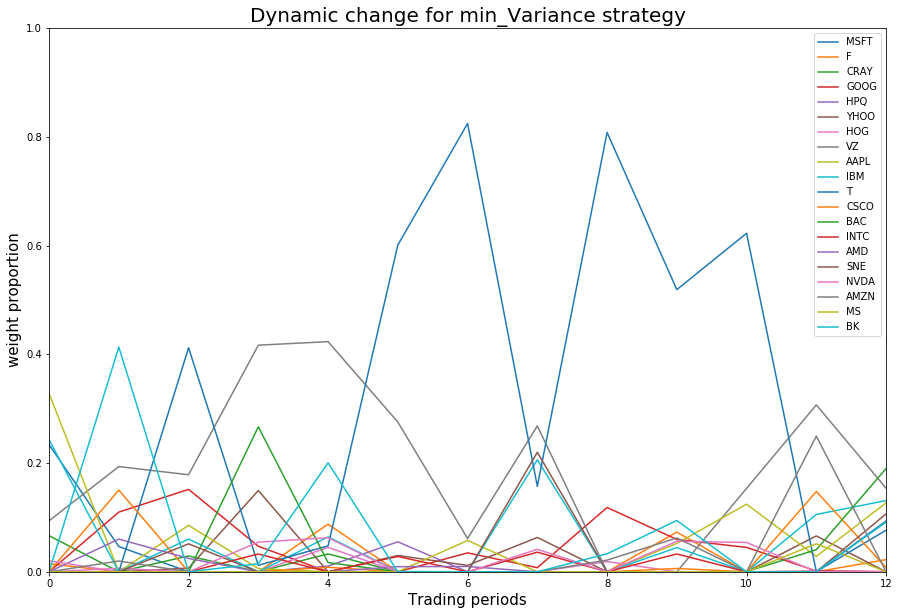

In [4]:
#Dynamic change for minimum Variance strategy

names = list(df.columns.values)
stock_names = names[1:]
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])
init_price = init_positions * data_prices[0,:]
init_value = np.dot(data_prices[0,:], init_positions)
w_initial = init_price / init_value

for i in range(20):
    stock_weight =[w_initial[i]]
    period = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    for j in range(12):
        stock_weight.append(weight[2][j][i])
    plt.plot(period,stock_weight, label = stock_names[i])
plt.legend()
plt.ylim([0,1])
plt.xlim([0,12])


plt.ylabel('weight proportion', fontsize=15);
plt.xlabel('Trading periods', fontsize=15);
plt.title('Dynamic change for min_Variance strategy', fontsize = 20);

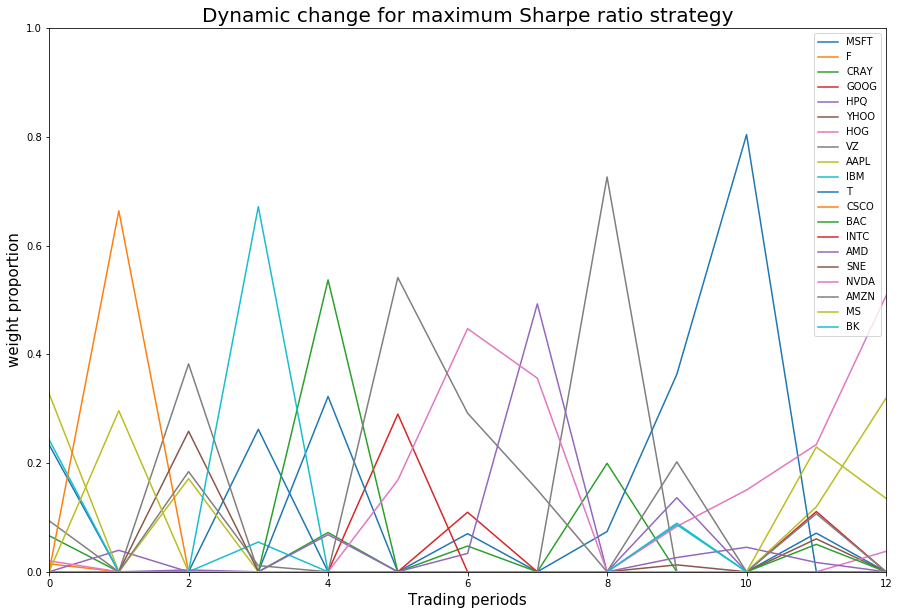

In [5]:
#Dynamic change for maximum sharpe ratio strategy

names = list(df.columns.values)
stock_names = names[1:]
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])
init_price = init_positions * data_prices[0,:]
init_value = np.dot(data_prices[0,:], init_positions)
w_initial = init_price / init_value

for i in range(20):
    stock_weight =[w_initial[i]]
    period = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    for j in range(12):
        stock_weight.append(weight[3][j][i])
    plt.plot(period,stock_weight, label = stock_names[i])
plt.legend()
plt.ylim([0,1])
plt.xlim([0,12])


plt.ylabel('weight proportion', fontsize=15);
plt.xlabel('Trading periods', fontsize=15);
plt.title('Dynamic change for maximum Sharpe ratio strategy', fontsize = 20);